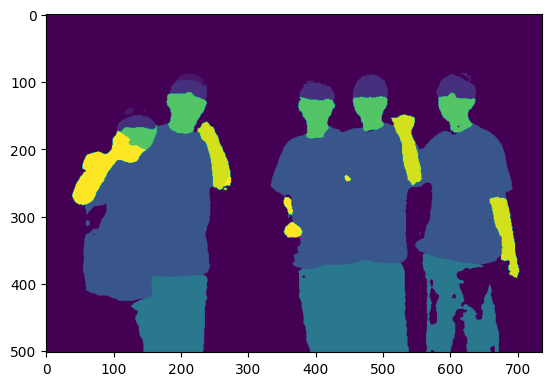

In [ ]:
# image는 23시즌 t1의 롤드컵 우승 사진입니다.

# 첫 번째 model은 image segmentation모델로 모델은 data의 상체, 하체, 얼굴, 팔 등의 부위를 segment하도록 훈련되었습니다.
# 결과 사진을 보면 가운데에 빈 부분이 트로피의 위치인데 인식하지 못한 것을 통해, 사람의 부위 seg만을 훈련하였음을
# 알 수 있고, 머리카락, 배경, 얼굴, 팔 등을 잘 구별해내었음을 알 수 있습니다.
# 모델 주소 : https://huggingface.co/mattmdjaga/segformer_b2_clothes

from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch.nn as nn

processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

url = "https://ifh.cc/g/gv9wky"

image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]
plt.imshow(pred_seg)

In [ ]:
# 두 번째 모델은 사람이 classes(label)에 포함되어있는 object detection 모델입니다.
# 결과를 보면 사람을 5명을 높은 confidence로 detect하였고, 이는 사진과 정확히 일치 합니다. 또한 다른 object를
# detect하지 않은 것을 보면 트로피나 조명 등은 labels에 포함되지 않았다고 유추 할 수 있습니다.

from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

url = "https://ifh.cc/g/gv9wky"
image = Image.open(requests.get(url, stream=True).raw)

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.60k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Detected person with confidence 0.999 at location [512.99, 81.09, 707.67, 499.76]
Detected person with confidence 0.949 at location [71.39, 84.74, 281.18, 499.52]
Detected person with confidence 0.993 at location [35.87, 133.66, 169.23, 499.78]
Detected person with confidence 0.996 at location [329.14, 90.38, 475.7, 499.88]
Detected person with confidence 0.989 at location [435.02, 85.93, 564.68, 499.61]


In [ ]:
!pip install transformers

In [ ]:
# bert-base-uncased 모델을 불러와서 감정 분석을 하였고, test결과 0.55, 0.45로 잘 분석하지 못함을 알 수 있습니다.
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

text = "실제 역사를 거의 그대로 다루다보니 보면서 화가 나긴 하지만 영화적으로 흥미롭게 구성을 잘해서 몰입도가 높아요. 몇 번을 봐도 볼 때마다 새롭게 보이는 면이 있구요. 의미와 재미를 다 잡은 작품이에요!"

inputs = tokenizer(text, return_tensors='pt')

outputs = model(**inputs)

probs = outputs.logits.softmax(dim=-1)

print(probs)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[0.5507, 0.4493]], grad_fn=<SoftmaxBackward0>)


In [ ]:
from datasets import load_dataset

dataset = load_dataset("yelp_review_full")

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/650000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [28]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
import torch
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

training_args = TrainingArguments(output_dir="test_trainer")

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch",num_train_epochs=3)

trainer = Trainer(
    model=model.to(device),
    args=training_args.to(device),
    train_dataset=small_train_dataset.to(device),
    eval_dataset=small_eval_dataset.to(device),
    compute_metrics=compute_metrics,

)

trainer.train()

text = "실제 역사를 거의 그대로 다루다보니 보면서 화가 나긴 하지만 영화적으로 흥미롭게 구성을 잘해서 몰입도가 높아요. 몇 번을 봐도 볼 때마다 새롭게 보이는 면이 있구요. 의미와 재미를 다 잡은 작품이에요!"

inputs = tokenizer(text, return_tensors='pt')

outputs = model(**inputs)

probs = outputs.logits.softmax(dim=-1)

print(probs)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U`